# Validation

In [1]:
# Setting seeds to try and ensure we have the same results - this is not guaranteed across PyTorch releases.
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import numpy as np
np.random.seed(0)

In [2]:
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn

mean, std = (0.5,), (0.5,)

# Create a transform and normalise data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                              ])

# Download FMNIST training dataset and load training data
trainset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download FMNIST test dataset and load test data
testset = datasets.FashionMNIST('~/.pytorch/FMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 16928211.05it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 297560.96it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4975490.94it/s]


Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21315179.66it/s]

Extracting /root/.pytorch/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FMNIST/FashionMNIST/raw



In [3]:
class FMNIST(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    x = F.log_softmax(x, dim=1)

    return x

model = FMNIST()

In [4]:
from torch import optim

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

num_epochs = 3

for i in range(num_epochs):
    cum_loss = 0

    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        cum_loss += loss.item()

    print(f"Training loss: {cum_loss/len(trainloader)}")

Training loss: 1.0341349944059275
Training loss: 0.5616475172769795
Training loss: 0.4920067817036277


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

images, labels = next(iter(testloader))

test_image_id = 0
img = images[test_image_id].view(1, 784)

with torch.no_grad():
    logps = model(img)

In [6]:
ps = torch.exp(logps)
ps

tensor([[2.3705e-06, 9.4471e-07, 1.3340e-05, 2.6119e-06, 7.0657e-06, 1.0298e-01,
         5.9918e-06, 5.1967e-01, 5.0446e-03, 3.7227e-01]])

In [7]:
nps = ps.numpy()[0]
nps

array([2.37051108e-06, 9.44707267e-07, 1.33398435e-05, 2.61188529e-06,
       7.06566880e-06, 1.02978423e-01, 5.99183340e-06, 5.19673884e-01,
       5.04460791e-03, 3.72270763e-01], dtype=float32)

<BarContainer object of 10 artists>

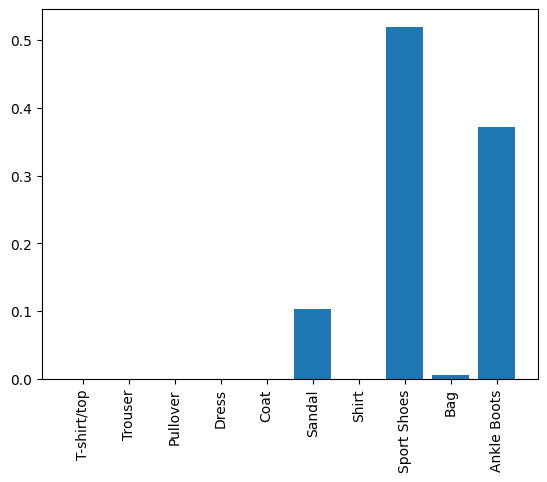

In [8]:
FMNIST_labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sport Shoes','Bag','Ankle Boots']
plt.xticks(np.arange(10),labels=FMNIST_labels,rotation='vertical')
plt.bar(np.arange(10), nps)

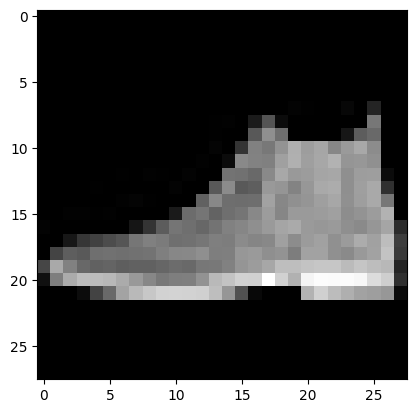

In [9]:
def denormalize(tensor):
  tensor = tensor*0.5 + 0.5
  return tensor

img = img.view(28,-1)
img = denormalize(img)
plt.imshow(img,cmap='gray')

In [10]:
with torch.no_grad():
    num_correct = 0
    total = 0

    cnt = 0
    for images, labels in testloader:

        logps = model(images)
        output = torch.exp(logps)
        print(output)
        cnt+=1

        if cnt > 0:
          break

tensor([[2.3705e-06, 9.4471e-07, 1.3340e-05, 2.6119e-06, 7.0657e-06, 1.0298e-01,
         5.9918e-06, 5.1967e-01, 5.0446e-03, 3.7227e-01],
        [6.9981e-04, 5.7816e-05, 9.5042e-01, 9.1200e-05, 1.4326e-02, 5.8311e-06,
         3.4065e-02, 4.7163e-09, 3.3923e-04, 2.0338e-07],
        [6.2727e-06, 9.9988e-01, 2.1912e-05, 5.9437e-05, 3.0694e-05, 1.0227e-08,
         7.5643e-08, 4.3015e-07, 1.5239e-09, 4.3086e-09],
        [1.7003e-06, 9.9970e-01, 2.6613e-05, 2.4829e-04, 2.4129e-05, 7.6917e-08,
         6.2570e-08, 1.9648e-06, 3.7890e-09, 2.5373e-08],
        [1.2294e-01, 1.4006e-03, 2.5262e-01, 1.6376e-02, 1.6295e-02, 2.5493e-04,
         5.8385e-01, 2.1190e-06, 6.2563e-03, 1.1421e-05],
        [8.3738e-04, 9.9299e-01, 6.6346e-04, 1.4449e-03, 4.0054e-03, 2.5665e-07,
         4.9611e-05, 3.7858e-06, 4.6079e-07, 1.2054e-07],
        [1.3390e-02, 2.5452e-03, 1.0458e-01, 1.2688e-03, 7.5056e-01, 1.3765e-04,
         1.2587e-01, 1.6473e-06, 1.6432e-03, 1.1616e-06],
        [7.0332e-03, 9.1429

In [11]:
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for images, labels in testloader:

        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)


In [12]:
pred, labels

(tensor([3, 1, 7, 5, 8, 2, 5, 2, 8, 9, 1, 9, 1, 8, 1, 5]),
 tensor([3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]))

In [13]:
pred == labels

tensor([ True, False,  True,  True,  True, False,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True])

In [14]:
with torch.no_grad():
    num_correct = 0
    total = 0

    #set_trace()
    for images, labels in testloader:

        logps = model(images)
        output = torch.exp(logps)

        pred = torch.argmax(output, 1)
        total += labels.size(0)
        num_correct += (pred == labels).sum().item()

    print(f'Accuracy of the model on the 10000 test images: {num_correct * 100 / total}% ')

Accuracy of the model on the 10000 test images: 81.72% 
